# Introduction - Scaffold analysis

We have already dealt extensively with chemical substructures in [exercise 5](../exercises/5_substructures_and_filters.ipynb). There, we have defined the observed substructures explicitly (MACCS and other structural keys) or implicitly (ECFP, other fingerprints). In this exercise, we will try to reduce chemical structures to their main structural motif, i.e. a central characteristic "framework" of the structure.

These "core" structural motifs, often called "scaffolds", are usually obtained by getting rid of all specifics about atoms (atom element, valence, charge, etc.) and bonds (bond type, bond order, etc.), chopping off all sidechains and keeping only the rings and the linkers between them. Some scaffolding methodologies will even contract linkers, normalize ring sizes, consecutively remove rings, etc. The role of scaffolds is to look upon chemical structures in a more abstract fashion, and to group them together based on shared central motifs.

Very popular scaffold type are what we call "Murcko scaffolds", obtained by normalizing all atoms and bonds of the processed structure, followed by sidechain removal. Some scaffolding methods are [implemented in RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.html), including the Murcko scaffolds we will use in this exercise.

Plenty of useful information about scaffolds can be viewed in the [OG article](https://sci-hub.tw/https://pubs.acs.org/doi/10.1021/jm9602928)

# Goals of the exercise:
 - Familiarize yourself with the concept of structural scaffolds. You probably already know it from the lecture materials, but just to be sure :)
 - Perform a scaffold analysis of the DrugBank database. Have a look at the most common scaffolds amongst drugs.
 - Perform a scaffold analysis of your ligand set. What are the most prevalent scaffolds/central structural motifs in your ligand set? 
 - Compare the scaffold composition of your ligand set and DrugBank. What are the differences? Are the scaffolds of your ligand set somewhat common amongst known drugs, or is it something more exotic?
 - Perform a scaffold-based diversity picking from your ligand set. Represent each scaffold in your ligand set by a single chemical structure.

# A story of Cytochrome P450 receptor

In [2]:
#loading necessary tools and packages
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

In [3]:
# loading my data
with open('Cytochrome_P450_targets.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    cytc_ligands = []
    for m in reader:
        mol = Chem.MolFromSmiles(m['Smiles'])
        # get the standardized pChEMBL activity measure for future use
        pchembl = m['pChEMBL Value']
        if not pchembl:
            # some don't have any comparable pChEMBL value, just assign them very low value
            pchembl = -1
        mol.SetDoubleProp('pChEMBL', float(pchembl)) # save the value into mol instance
        cytc_ligands.append(mol)

# loading drugbank data       
suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [20:39:29] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [20:39:29] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [20:39:29] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [20:39:29] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [20:39:29] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [20:39:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [20:39:30] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [20:39:30] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [20:39:30] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [20:39:30] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [20:39:30] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [20:39:30] Can't kek

Let's have a look at the random ligand in our set:

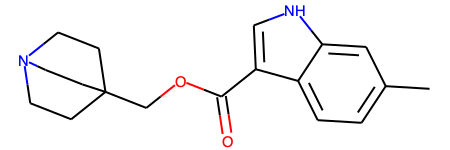

In [8]:
#First ligand in my set
cytc_ligands[8]

Let's try to get its scaffold:

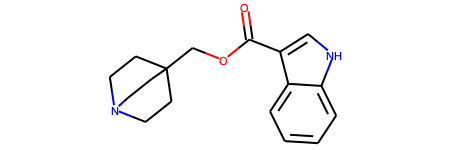

In [11]:
from rdkit.Chem.Scaffolds import MurckoScaffold
scaffold1 = MurckoScaffold.GetScaffoldForMol(cytc_ligands[8])
scaffold1

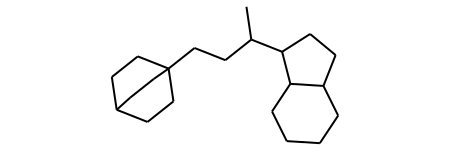

In [12]:
scaffold2 = MurckoScaffold.MakeScaffoldGeneric(scaffold1)
scaffold2

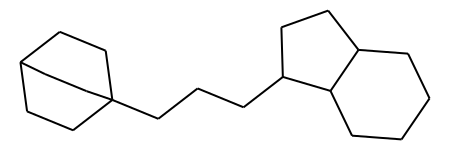

In [13]:
scaffold3 = MurckoScaffold.GetScaffoldForMol(scaffold2)
scaffold3

It gives us the barebone Murcko scaffold of our first ligand. The Bemis–Murcko scaffold of a compound was defined to consist of all of its ring structures and linker fragments connecting rings. Thus, a scaffold was obtained from a compound by removing all substituents (R-groups). All heteroatoms, bonds, sidechains are abstracted away. For more convenience, let's implement the scaffolding process as a function:

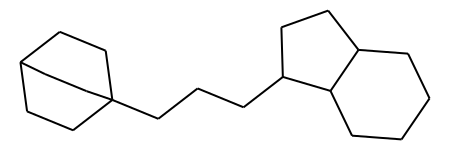

In [14]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff
scaffold(cytc_ligands[8])

The function seems to work fine, we can go ahead. Let's scaffold all drugs in DrugBank and those for my dataset:

In [33]:
cyt_scaffolds = [scaffold(i) for i in cytc_ligands]
cyt_scaffolds[20:30]

RDKit ERROR: [21:19:34] Explicit valence for atom # 23 C, 6, is greater than permitted
RDKit ERROR: [21:19:35] Explicit valence for atom # 23 C, 6, is greater than permitted
RDKit ERROR: [21:19:35] Explicit valence for atom # 24 C, 6, is greater than permitted
RDKit ERROR: [21:19:35] Explicit valence for atom # 24 C, 6, is greater than permitted
RDKit ERROR: [21:19:35] Explicit valence for atom # 24 C, 6, is greater than permitted
RDKit ERROR: [21:19:37] Explicit valence for atom # 23 C, 6, is greater than permitted
RDKit ERROR: [21:19:37] Explicit valence for atom # 15 C, 6, is greater than permitted


In [35]:
drugbank_scaffolds = [scaffold(drug) for drug in drugs]
drugbank_scaffolds[20:30]

RDKit ERROR: [21:20:02] Explicit valence for atom # 90 C, 6, is greater than permitted
RDKit ERROR: [21:20:02] Explicit valence for atom # 62 C, 6, is greater than permitted
RDKit ERROR: [21:20:03] Explicit valence for atom # 6 C, 6, is greater than permitted
RDKit ERROR: [21:20:03] Explicit valence for atom # 31 C, 6, is greater than permitted
RDKit ERROR: [21:20:03] Explicit valence for atom # 14 C, 10, is greater than permitted
RDKit ERROR: [21:20:04] Explicit valence for atom # 23 C greater than permitted
RDKit ERROR: [21:20:04] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [21:20:04] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [21:20:04] Explicit valence for atom # 40 C, 6, is greater than permitted
RDKit ERROR: [21:20:04] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [21:20:04] Explicit valence for atom # 31 C, 6, is greater than permitted
RDKit ERROR: [21:20:05] Explicit valence for atom # 2

Of course, the generated scaffolds are all RDKit Mol instances. For easy comparison, let's turn them into SMILES strings. Identical scaffolds = identical scaffold SMILES = identical text strings. Comparing instances directly would be much less convenient.

In [36]:
cyt_scaffolds_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(cyt_scaffolds) if mol]
cyt_scaffolds_smiles[20:30]

[(20, 'C1CCC(CCCCC2CCCC(CCC3CCC(C4CCCCC4)C3)C2)CC1'),
 (21, 'C1CCC(CCC2CC3CC(C4CCCCC4)CC3C2)CC1'),
 (22, 'C1CCC(CC2CCC(CCCC3CC4CCCCC4C3)CC2)C1'),
 (23, 'C1CCC(C2CCC3C(CCC4CC(C5CCCCC5)CC43)C2)CC1'),
 (24, 'C1CCC(CCCC2CCC3CCCCC3C2)CC1'),
 (25, 'C1CCC(CC2CCC(C3CCCCC3)CC2)CC1'),
 (26, 'C1CCC(C2CCC(CCC(C3CCCCC3)C3CCCCC3)CC2)CC1'),
 (27, 'C1CCC(CCC2CCC3CC(C4CCC5CCCCC54)CCC23)CC1'),
 (28, 'C1CCC(CCCCC2CCC(C3CCCCC3)CC2)CC1'),
 (29, 'C1CCC(CCCC2CCC(C3CCCCC3)CC2)CC1')]

In [37]:
drugbank_scaffolds_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drugbank_scaffolds) if mol]
drugbank_scaffolds_smiles[20:30]

[(21, ''),
 (22, ''),
 (23, 'C1CCC2C(C1)CCC2C1CCCC1'),
 (24, ''),
 (25, ''),
 (26, ''),
 (27, 'C1CCCCC1'),
 (28, 'C1CCC(CCC2CCCC3CCCC32)CC1'),
 (29, 'C(CCCCCCCCCC1CCCCC1)CCCCCCCCC1CCCCC1'),
 (30, '')]

For mydataset all structures from range 20 to 30 had a scaffold. Apparently some structures have no scaffolds (or, in other terms, have zero-atom scaffolds). Let's have a look at structure with index 21 in drugbank dataset, the first with such a non-scaffold:

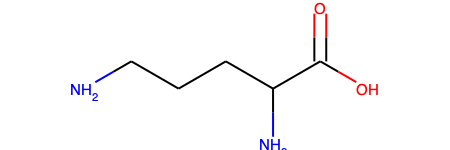

In [18]:
drugs[21]

The structure with index 22,24,25,26 and 30 in the drugbank dataset were not scaffolded at all. Let's have a look at it:

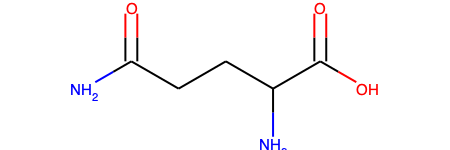

In [19]:
drugs[22]

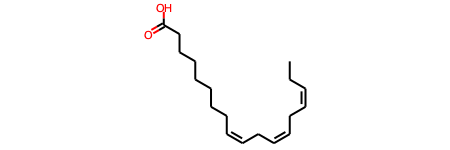

In [20]:
drugs[24]

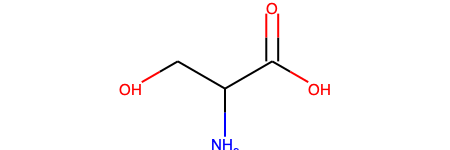

In [21]:
drugs[25]

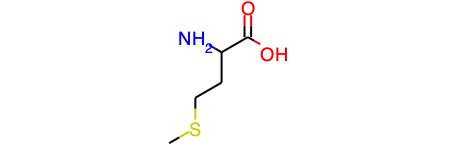

In [22]:
drugs[26]

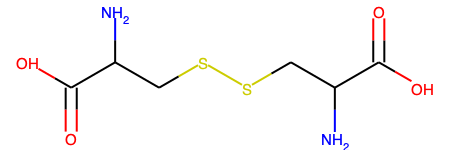

In [23]:
drugs[30]

In [12]:
scaffolds2drugs = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles}
for drug_idx, scaffoldsmiles in drugbank_scaffolds_smiles:
    scaffolds2drugs[scaffoldsmiles].append(drug_idx)
scaffolds2drugs

{'C(CCCCCCCCCCCC(CCCCCCCCCCC1CCCC1CCCCCCCCCCC1CCCCC1)CC1CCCCC1)CCCCCCCCCCCC1CCCC1CCCCC1CCCC1CCCC1CCCCC1': [0,
  2059],
 'C(CCCCCC(CCCCCC(CCC(CCC1CCCC1)CC1CCCC1)CC1CCC2CCCCC21)CC1CCCCC1)CCCCC1CCCC1': [1,
  529],
 'C1CCCCC(CC2CCCCC2)CCC(CC2CCCCC2)CCCCCCCC(CC2CCCC2)CCC1': [2, 5, 2324],
 'C(CCCCCC(CCCCCC(CCC(CCCCC1CCC2CCCCC2C1)CC1CCCCC1)CC1CCCCC1)CC1CCCCC1)CCCCC1CCCC1': [3,
  4676],
 'C1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1': [4],
 'C1CCCCCCC(CCCCC2CCCCC2)CCC(CC2CCCCC2)CCC(CC2CCC3CCCCC32)CCCCCC1': [6],
 'C1CCCCC1': [7,
  13,
  27,
  39,
  54,
  56,
  59,
  67,
  72,
  73,
  78,
  81,
  82,
  89,
  102,
  108,
  112,
  123,
  126,
  127,
  131,
  134,
  149,
  154,
  155,
  161,
  171,
  181,
  192,
  196,
  198,
  202,
  206,
  224,
  228,
  234,
  257,
  258,
  268,
  276,
  285,
  305,
  306,
  310,
  315,
  318,
  333,
  336,
  346,
  350,
  361,
  370,
  375,
  376,
  378,
  381,
  386,
  408,
  416,
  429,
  430,
  435,
  443,
  459,
  477,
  479,
  484,
  494,
  495,
  497,
  512,
  514,

In [56]:
scaffolds2drugs2 = {scaffol:[] for cyt_idx, scaffol in cyt_scaffolds_smiles}
for cyt_idx, scaffol in cyt_scaffolds_smiles:
    scaffolds2drugs2[scaffol].append(cyt_idx)
scaffolds2drugs2

{'C1CCC(CC2CCC3CCCCC32)CC1': [0,
  396,
  440,
  478,
  479,
  510,
  574,
  675,
  865,
  996,
  1456,
  1476,
  1771,
  2008,
  2410,
  2687,
  2996,
  3524,
  3638,
  4018,
  4326,
  4470,
  4727,
  4743,
  4798,
  5026,
  5099,
  5165,
  5462,
  5595,
  5784],
 'C1CCC(CCC2CC(CC3CCCCC3)CC3CCCC32)CC1': [1,
  706,
  776,
  1559,
  1834,
  3541,
  3994,
  4895,
  5262,
  5295,
  5589,
  5668],
 'C(CCC1CC2CCCC2C1)CC1CCC1': [2, 2406, 5840],
 'C1CCC(CCCC2CCC(C3CCCCC3)CC2)CC1': [3,
  29,
  77,
  204,
  238,
  594,
  595,
  655,
  1021,
  1022,
  1075,
  1198,
  1292,
  1293,
  1377,
  1597,
  1602,
  1763,
  1767,
  2378,
  2605,
  2606,
  2951,
  2985,
  3060,
  3124,
  3331,
  3719,
  3895,
  4101,
  4352,
  4499,
  4685,
  4826,
  4891,
  5131,
  5132],
 'C1CCC(C2CCC(CCC34CCC(CC3)C4)CC2)CC1': [4],
 'C1CCC(C(CC2CCCC2)CC2CCC3CCCCC3C2)CC1': [5, 5476],
 'C1CCC(C2CCC(CC3CCC(C4CCCCC4)CC3)CC2)CC1': [6,
  49,
  300,
  301,
  619,
  723,
  733,
  734,
  735,
  812,
  1009,
  1277,
  1346,
  1347

Above, we have a dictionary with scaffold SMILES, mapping to IDs of the drugs which contain them. We can count the IDs assigned to each scaffold to get an idea which scaffolds are most frequent amongst drugs:

In [57]:
scaffold_drugcount = [(scaffold, len(drugs)) for scaffold, drugs in scaffolds2drugs.items()]
len(scaffold_drugcount), scaffold_drugcount[20:30]

(1545,
 [('C(CCCC1CCC2CCCC12)CCC1CCCCC1', 2),
  ('C1CCC(CCCCC2CCCCC2)CC1', 53),
  ('C1CCC2C(C1)CCC1C2CCC2C3CCCC3CC21', 8),
  ('C(CCCCCCC1CCC2CCCCC12)CCCCCC1CCCCC1', 1),
  ('C1CCC(C2CCCC2)CC1', 176),
  ('C1CCC2(C1)CC1CCC2CC1', 1),
  ('C1CCC(C2CCCCC3CCCCC32)CC1', 21),
  ('C1CCC2C(C1)CC1CCCCC12', 21),
  ('C1CCC(C2CCCCC2)CC1', 105),
  ('C1CCC(CCCCC2CC2)CC1', 2)])

In [61]:
scaffold_cytcount = [(scaffold, len(cytc_ligand)) for scaffold, cytc_ligand in scaffolds2drugs2.items()]
len(scaffold_cytcount), scaffold_cytcount[20:30]

(1736,
 [('C1CCC(CC2CCC(CCCC3CC4CCCCC4C3)CC2)C1', 7),
  ('C1CCC(C2CCC3C(CCC4CC(C5CCCCC5)CC43)C2)CC1', 13),
  ('C1CCC(CC2CCC(C3CCCCC3)CC2)CC1', 30),
  ('C1CCC(C2CCC(CCC(C3CCCCC3)C3CCCCC3)CC2)CC1', 1),
  ('C1CCC(CCC2CCC3CC(C4CCC5CCCCC54)CCC23)CC1', 3),
  ('C1CCC(CCCCC2CCC(C3CCCCC3)CC2)CC1', 21),
  ('C1CCC(C2CCC3CCCC3C2)CC1', 31),
  ('C1CCC(CCCC2CCCCC2CCC2CCC(CC3CCCC3)C3CCCCC23)CC1', 2),
  ('C1CCC(CCC2CC(C3CCCC3)CC3CCCC32)CC1', 11),
  ('C1CCC(CCC2CCC(C3CCCCC3)CC2)CC1', 4)])

In [62]:
scaffold_drugcount.sort(key=lambda x: x[1], reverse=True)
scaffold_drugcount[20:30]

[('C1CCC(C2CCC3CCCCC32)CC1', 32),
 ('C(CCCC1CCCCC1)CCC1CCCCC1', 30),
 ('C1CCC(CCCC2CCCC2)CC1', 30),
 ('C1CCC(CCCCCC2CCCCC2)CC1', 29),
 ('C1CCC(CCC2CCCC3CCCC32)CC1', 28),
 ('C1CCC(CC2CCCC3CCCCC32)CC1', 26),
 ('C1CCC(CC2CCC3CCCCC32)CC1', 25),
 ('C1CCC(CC2CCC3CCCCC3C2)CC1', 22),
 ('C1CCC(C2CCCCC3CCCCC32)CC1', 21),
 ('C1CCC2C(C1)CC1CCCCC12', 21)]

In [63]:
scaffold_cytcount.sort(key=lambda x: x[1], reverse=True)
scaffold_cytcount[20:30]

[('C1CCC(CCC2CC3CCCCC3C2)CC1', 34),
 ('C1CCC(CCCC2CCCC2)CC1', 33),
 ('C1CCC(CCCC2CCC(CC3CCCCC3)CC2)CC1', 33),
 ('C1CCC(CCC2CCCCC2)CC1', 32),
 ('C1CCC(CC2CCC3CCC(C4CCCCC4)CC32)CC1', 32),
 ('C1CCC(CC2CCC3CCCCC32)CC1', 31),
 ('C1CCC(C2CCC3CCCC3C2)CC1', 31),
 ('C1CCC(CCC2CC(C3CCCCC3)CC3CCCC32)CC1', 31),
 ('C1CCC(CC2CCC3(CC2)CC(C2CCC(C4CCCCC4)CC2)CC3C2CCCCC2)CC1', 31),
 ('C1CCC(CC2CCC(C3CCCCC3)CC2)CC1', 30)]

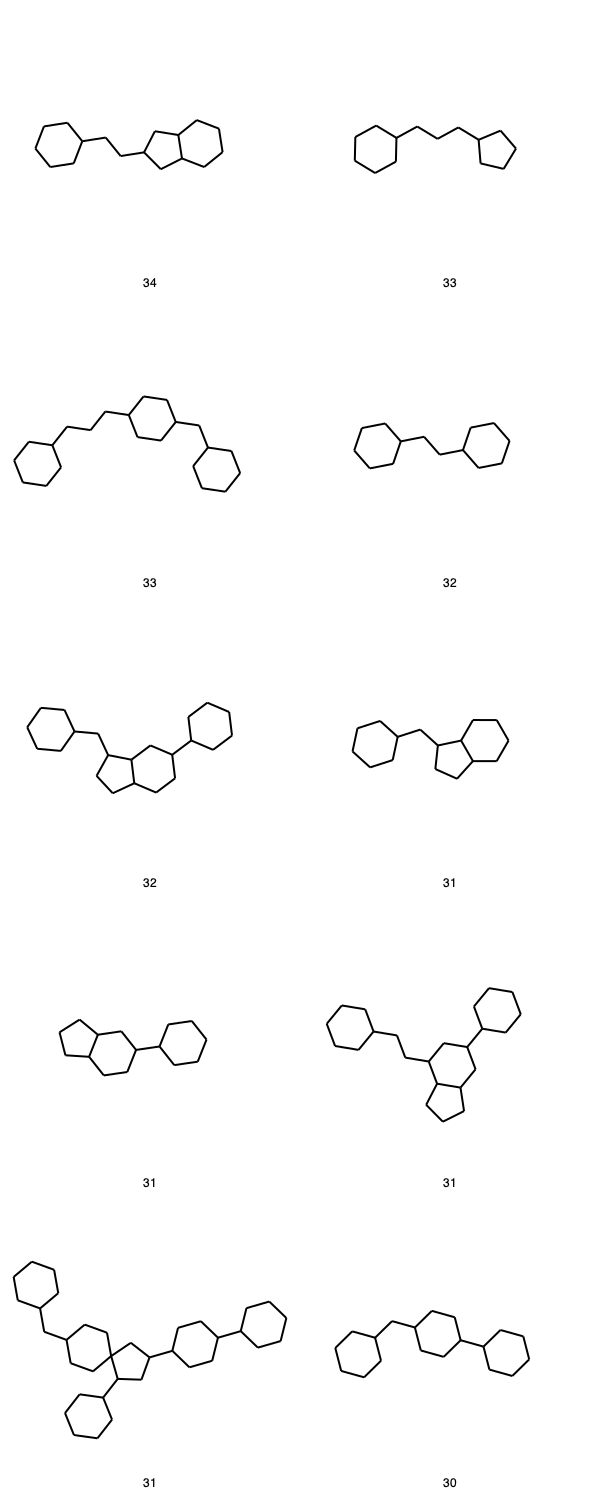

In [64]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_cytcount[20:30]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in scaffold_cytcount[20:30]])

Above, we have the most common Murcko scaffolds within my dataset. 

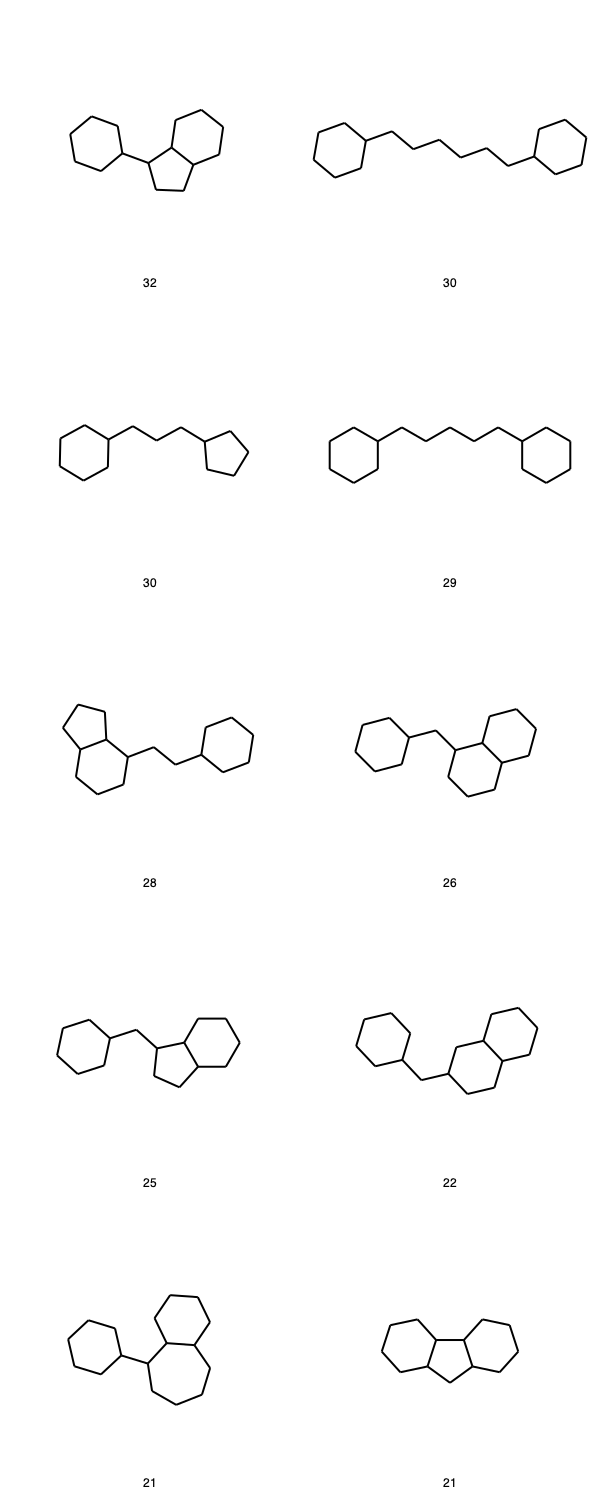

In [65]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in scaffold_drugcount[20:30]],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in scaffold_drugcount[20:30]])

## Scaffold-based diversity picking

In the [previous exercise](../exercises/8_structural_similarity.ipynb), we ended with some diversity picking to select a small, yet still representative subset of our full set of ligands. There, we used their mutual (dis)similarity. Another approach for picking a representative subset is, as you have probably already guessed, by scaffolds. This is done quite often for the purposes of [chemical space exploration](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3998053/), but can be just as easily used to present chemists with some actual structures that back up the more abstract scaffold analysis.

This type of diversity picking is quite straightforward in concept, it just means representing each scaffold by a single structure (often the most potent one), or some sort of [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) from various scaffolds.

Let's try the simplest approach, and represent each scaffold in our ligand set by its most active (by pChEMBL value) ligand:

In [67]:
scaffold_representatives = {}
for scaffold, ligands in scaffolds2drugs2.items():
    scaffold_representatives[scaffold] = sorted(ligands,
                                                key=lambda x: cytc_ligands[x].GetProp('pChEMBL'),
                                                reverse=True)[0]
len(scaffold_representatives), scaffold_representatives

(1736,
 {'C1CCC(CC2CCC3CCCCC32)CC1': 510,
  'C1CCC(CCC2CC(CC3CCCCC3)CC3CCCC32)CC1': 3994,
  'C(CCC1CC2CCCC2C1)CC1CCC1': 2,
  'C1CCC(CCCC2CCC(C3CCCCC3)CC2)CC1': 204,
  'C1CCC(C2CCC(CCC34CCC(CC3)C4)CC2)CC1': 4,
  'C1CCC(C(CC2CCCC2)CC2CCC3CCCCC3C2)CC1': 5476,
  'C1CCC(C2CCC(CC3CCC(C4CCCCC4)CC3)CC2)CC1': 5598,
  'C1CCC(CCC2CC3CCC(C4CCCCC4)CC3C2)CC1': 4540,
  'C1CCC2C(C1)CCC2CCCC12CCC(CC1)CC2': 8,
  'C1CCC(CCC2CCC3C(CCC4CC(C5CCCCC5)CC43)C2)CC1': 9,
  'C1CCC(CCC2CCCC(CC3CC4CCCCC4C3)C2)CC1': 10,
  'C1CCC(CC2CCCCC2)CC1': 941,
  'C1CCC(C2CCCCC3CCCCC32)CC1': 12,
  'C1CCC(CC2CCC(CCC3CCC4CC(C5CC56CCC5CCCCC56)CCC34)CC2)CC1': 4328,
  'C(CCCCC1CCCC2CC3CCCCC3C12)CCCC1CCCCC1': 14,
  'C1CCC2C(C1)CC1CCCCC1C1CCCCC21': 15,
  'C1CCC(CCCC2CCC3CCCCC3C2)CC1': 2586,
  'C1CCC(C2CCC3C(CCCC3C3CCCCC3)C2)CC1': 3542,
  'C1CCC(CCCCC2CCCC(CCC3CCC(C4CCCCC4)C3)C2)CC1': 2761,
  'C1CCC(CCC2CC3CC(C4CCCCC4)CC3C2)CC1': 1577,
  'C1CCC(CC2CCC(CCCC3CC4CCCCC4C3)CC2)C1': 343,
  'C1CCC(C2CCC3C(CCC4CC(C5CCCCC5)CC43)C2)CC1': 23,
  'C

In [69]:
# prep for our amazing visualization of scaffolds and representative structures side by side :)
scaffold_representatives4visualization = []
for scaffold, ligandcount in scaffold_cytcount:
    mol = Chem.MolFromSmiles(scaffold)
    mol.SetProp('legend', str(ligandcount) + " ligands")
    scaffold_representatives4visualization.append(mol)
    representative_mol = cytc_ligands[scaffold_representatives[scaffold]]
    representative_mol.SetProp('legend', "#{} | pChEMBL {}".format(str(scaffold_representatives[scaffold]),
                                                            representative_mol.GetProp('pChEMBL')))
    scaffold_representatives4visualization.append(representative_mol)
len(scaffold_representatives4visualization), scaffold_representatives4visualization[:20]

(3472,
  <rdkit.Chem.rdchem.Mol at 0x7feb29700c60>])

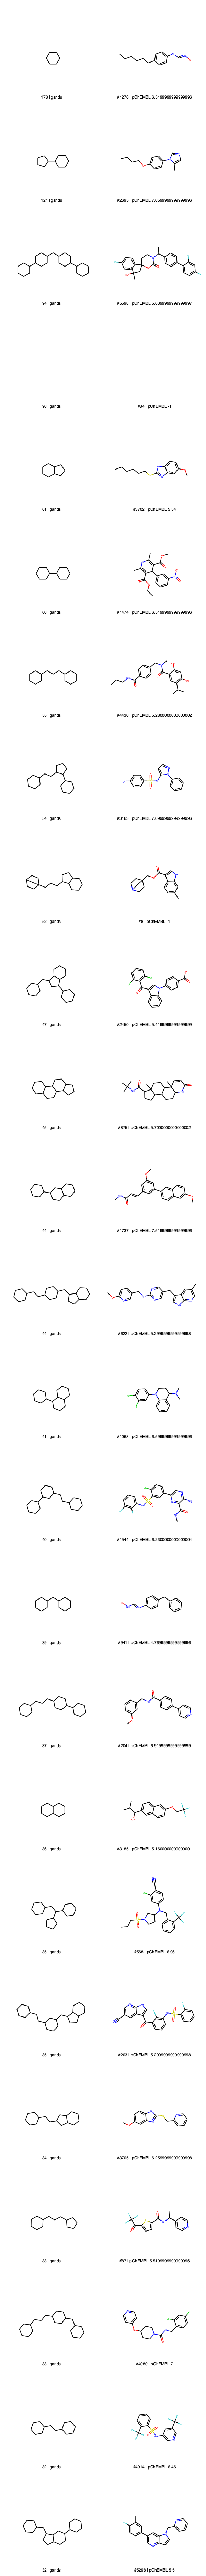

In [70]:
# visualizing structures
Draw.MolsToGridImage(scaffold_representatives4visualization[:50],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[mol.GetProp('legend')
                              for mol in scaffold_representatives4visualization[:50]])